In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os      # use it to do directory/folders operations
import cv2     # need this for cv2.imread('image') which converts an image to an array
import tensorflow as tf
import random
import seaborn as sn
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten

## 1) Exploring the dataset

Quoting the description from Kaggle : "The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal) "

In [2]:
data_folders = ['train', 'test', 'val']
categories = ['NORMAL', 'PNEUMONIA']
labels = [0,1]
train = []; test = []; val = [];
sets = [train, test, val]

In [3]:
img_size = 224

In [4]:
for data_folder,set in zip(data_folders, sets) :
    
    data_dir = "C:/Users/Vaggelis/Documents/Machine_Learning/image_classification/chest_pneumonia_dataset/chest_xray/{}".format(data_folder)
    
    for category,label in zip(categories, labels):
        
        path = os.path.join (data_dir, category) 
        for img in os.listdir(path):     
            dir_for_image = os.path.join(path,img)
            img_array= cv2.imread(dir_for_image)
            img_array = cv2.resize( img_array , (img_size, img_size) )
            set.append([img_array,label])
        random.shuffle(set)
        
        if set == sets[0]:
            x_train = []; y_train = []
            for j in range(len(set)):
                x_train.append(set[j][0])
                y_train.append(set[j][1])
            y_train = np.array(y_train)
            
        if set == sets[1]:
            x_test = []; y_test = []
            for j in range(len(set)):
                x_test.append(set[j][0])
                y_test.append(set[j][1])
            y_test = np.array(y_test)
            
        if set == sets[2]:
            x_val = []; y_val = []
            for j in range(len(set)):
                x_val.append(set[j][0])
                y_val.append(set[j][1])
            y_val = np.array(y_val)

In [5]:
print('The training set consists of ',len(x_train), ' images')
print('The test set consists of ',len(x_test), ' images')
print('The validation set consists of ',len(x_val), ' images')

The training set consists of  5216  images
The test set consists of  624  images
The validation set consists of  16  images


In the above part we have defined the training, test and validation sets.

We are going to use the training and test sets to tune the hyperparamenters of our models, and only in the end we will use the validation set to test our final models on unseen data. 

Rmk : Usually, in the literature, the "validation" set is used to tune the mode's hyper-parameters and the "test" set to test the final model on unseen data. However, the dataset constructor has put very few images in the validation set and much more in the test set, so we are going to use them inversly as explained above.

#### Let's print a few images from the training set of people who are suffer from pneumonia and a few of people who do not :

images of people who suffer from pneumonia


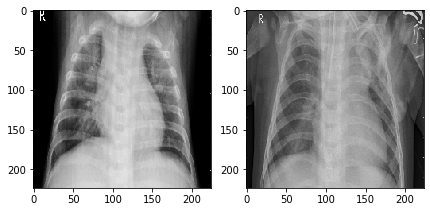

In [6]:
plt.figure(figsize=(7,7))

print('\033[1m' + 'images of people who suffer from pneumonia')
r = np.arange(len(x_train))
i = r[y_train==1]
ax = plt.subplot(1,2,1)
plt.imshow(x_train[i[0]])
ax = plt.subplot(1,2,2)
plt.imshow(x_train[i[1]])

images of people who do not suffer from pneumonia


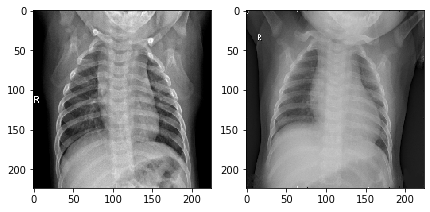

In [7]:
plt.figure(figsize=(7,7))

print('\033[1m' + 'images of people who do not suffer from pneumonia')
r = np.arange(len(x_train))
i = r[y_train==0]
ax = plt.subplot(1,2,1)
plt.imshow(x_train[i[0]])
ax = plt.subplot(1,2,2)
plt.imshow(x_train[i[1]])

#### Data normalization

In [8]:
max_value = max(np.max(x_train), np.max(x_val), np.max(x_test))

x_train = x_train/max_value
x_val = x_val/max_value
x_test = x_test/max_value

## 2) 1st classifier : CNN model with Image Augmentation

#### 2.1) Build the augmented image set

In [9]:
train_datagen = ImageDataGenerator(rescale=None, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=None, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

In [10]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=30)
test_generator = val_datagen.flow(x_test, y_test, batch_size=20)

#### 2.2 ) The model 

In a spare notebook, we **GridSearch-ed** hyper-tuned the neural network classifier with respect to the number of hidden convolutional and dense layers (0,1 or 2), the size of the kernel ( (2,2), (3,3) and (4,4)), the number of the activation maps per payer (16, 32, 63 and 128) and the number of nodes in the hidden dense layers ( 32, 64, 128 and 256).

We chose the one with the best test_accuracy.

We didn't cross-validate each classifier due to the laptop's limited computational power.

In the interest of space we do not present here also the training of the rejected models.

In [11]:
model1 = Sequential()

model1.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(img_size,img_size,3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])          

In [12]:
h1 = model1.fit_generator(train_generator, 
                         epochs=50,
                    validation_data=test_generator)    

Epoch 1/50
174/174 [==============================] - 384s 2s/step - loss: 0.4465 - accuracy: 0.7839 - val_loss: 0.4857 - val_accuracy: 0.7804
Epoch 2/50
174/174 [==============================] - 367s 2s/step - loss: 0.3620 - accuracy: 0.8276 - val_loss: 0.4959 - val_accuracy: 0.7484
Epoch 3/50
174/174 [==============================] - 366s 2s/step - loss: 0.3166 - accuracy: 0.8533 - val_loss: 0.4099 - val_accuracy: 0.8205
Epoch 4/50
174/174 [==============================] - 367s 2s/step - loss: 0.2902 - accuracy: 0.8740 - val_loss: 0.5107 - val_accuracy: 0.7692
Epoch 5/50
174/174 [==============================] - 368s 2s/step - loss: 0.2894 - accuracy: 0.8763 - val_loss: 0.4186 - val_accuracy: 0.8317
Epoch 6/50
174/174 [==============================] - 367s 2s/step - loss: 0.2539 - accuracy: 0.8907 - val_loss: 0.4181 - val_accuracy: 0.8381
Epoch 7/50
174/174 [==============================] - 366s 2s/step - loss: 0.2529 - accuracy: 0.8965 - val_loss: 0.3711 - val_accuracy: 0.8429

#### 2.3) Model evaluation 

#### Learning curve

<IPython.core.display.Javascript object>


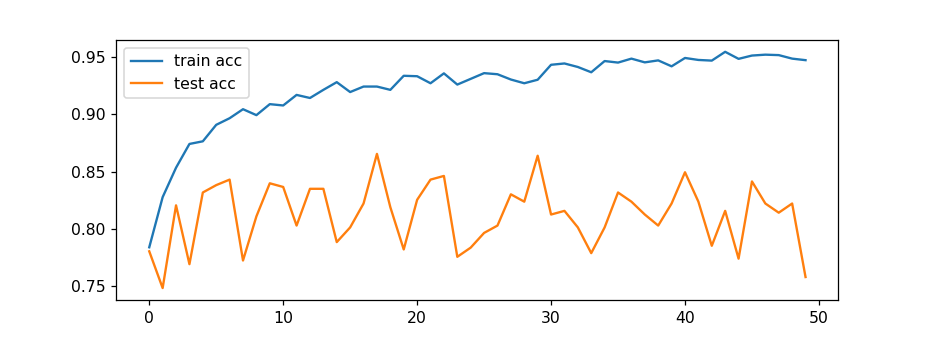

In [15]:
%matplotlib notebook
plt.figure()
plt.plot(h1.history['accuracy'])
plt.plot(h1.history['val_accuracy'])
plt.legend(['train acc', 'test acc'])

In the above curve we observe obvious signs of **overfitting**. Below we see that indeed this model does not behave well over the unseen data of the validation set as it achieves accuracy only 0.56.

#### Predictions on unseen data : Confusion matrix & Classification report

<IPython.core.display.Javascript object>


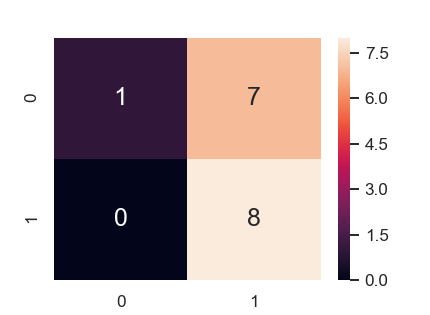

In [16]:
rounded_pred1 = model1.predict_classes(x_val, verbose=0)
cm1 = confusion_matrix(y_val, rounded_pred1)

df_cm1 = pd.DataFrame(cm1, range(2), range(2))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm1, annot=True, annot_kws={"size": 16})
plt.show()

In [17]:
cr1 = classification_report(y_val, rounded_pred1)
print(cr1)

              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16



## 3) 2nd classifier : Use pre-trained ResnetNN for feature extraction

#### 3.1) The model

We import the ResnetNN, remove its top layers and flatten the output of the convolutional layers. In that way we construct the resnet_model which takes an image as input and returns its features based on the pre-trained convolutional layers of the ResnetNN model.

In [18]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))
output = resnet.layers[-1].output
output = Flatten()(output)
resnet_model = Model(resnet.input, output)

We get the features of the images included in the training and the test set.

In [19]:
x_train_feat = resnet_model.predict(x_train, verbose=0)
x_test_feat = resnet_model.predict(x_test, verbose=0)

Now, we define a DNN clasifier which achieves a satisfying accuracy over the test set and it does not overfit very much the data at the same time.

Similarly to the previous case, this final classifier was choosen among many different **GridSearch-ed** classifiers tested in a spare notebook by comparing its test accuracy to other models.

Due to laptop's limited power we did not cross validate each model.

It is hyper-tuned over the number of hidden dense layers (1 or 2) , the number of hidden nodes (64 or 16) and the activation function of each hidden layer (relu or linear).

In the interest of space we skip the training of the rejected models in this notebook.

In [20]:
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_dim = resnet_model.output_shape[1]))
model2.add(Dense(16, activation = 'relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
h2 = model2.fit(x_train_feat, y_train,
         epochs = 50,
         validation_data = (x_test_feat, y_test))

Train on 5216 samples, validate on 624 samples
Epoch 1/50
5216/5216 [==============================] - 32s 6ms/sample - loss: 0.4631 - accuracy: 0.8265 - val_loss: 1.1144 - val_accuracy: 0.6587
Epoch 2/50
5216/5216 [==============================] - 27s 5ms/sample - loss: 0.2533 - accuracy: 0.8951 - val_loss: 0.4845 - val_accuracy: 0.7740
Epoch 3/50
5216/5216 [==============================] - 27s 5ms/sample - loss: 0.1800 - accuracy: 0.9262 - val_loss: 0.4377 - val_accuracy: 0.7949
Epoch 4/50
5216/5216 [==============================] - 28s 5ms/sample - loss: 0.1913 - accuracy: 0.9247 - val_loss: 0.6875 - val_accuracy: 0.7404
Epoch 5/50
5216/5216 [==============================] - 28s 5ms/sample - loss: 0.1679 - accuracy: 0.9354 - val_loss: 1.3169 - val_accuracy: 0.6683
Epoch 6/50
5216/5216 [==============================] - 27s 5ms/sample - loss: 0.1747 - accuracy: 0.9314 - val_loss: 0.5853 - val_accuracy: 0.7708
Epoch 7/50
5216/5216 [==============================] - 27s 5ms/sample 

In [22]:
#save model
model2.save('feature_extraction_model.h5')

#### 3.2)  Model evaluation

#### Learning curve

<IPython.core.display.Javascript object>


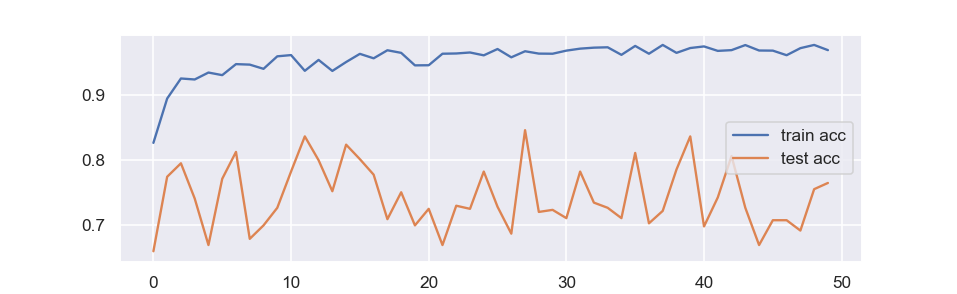

In [26]:
%matplotlib notebook
plt.figure()
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.legend(['train acc', 'test acc'])

We observe that while the accuracy over the training set is quite satisfying after only a few epochs there are signs of **overfitting**, even for this optimal among other model.

#### Predictions on unseen data : Confusion matrix & Classification report

<IPython.core.display.Javascript object>


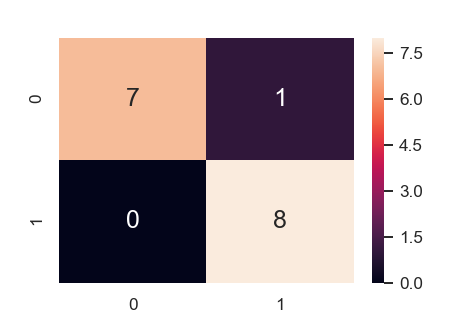

In [27]:
x_val_feat = resnet_model.predict(x_val)
rounded_pred2 = model2.predict_classes(x_val_feat, verbose=0)

cm2 = confusion_matrix(y_val, rounded_pred2)

df_cm2 = pd.DataFrame(cm2, range(2), range(2))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm2, annot=True, annot_kws={"size": 16})
plt.show()

In [28]:
cr2 = classification_report(y_val, rounded_pred2)
print(cr2)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



## 4) Summary / Comparison of the classifiers

- We are interested in **detecting pneumonia cases**. Thus we focus on classifying as correctly as possible the **"1" label**.

In this context, we highlight that the Recall metric is of prior importance for us. It should be as close to "1" as possible,
since obviously we would not like to classify pneumonia cases as normal.

Below we see the results obtained by the confusion matrices :

1st classifier : Accuracy = 0.56, Recall = 1, Precision = 0.53, f1-score = 0.7

**2nd classifier : Accuracy = 0.94, Recall = 1, Precision = 0.89, f1-score = 0.94**

We observe that both models achieve perfect Recall score "1". However, with respect to Accuracy, Precision and f1-score, we see that overall the 2nd classifier is superior, as it achieves much better results in all other metrics.

- As we see in the learning curves both models **overfit** the data (the first classifier much more though). **Thus**, even if the second model (model2) behaves very well over these specific unseen data, we might be a **bit luckly** to get so good classification results.

### 5) Additional material to be added in the future.
1. We are going to build a **3rd classifier** by **fine-tuning a a pre-trained ResnetNN**. More specifically, we will adapt a DNN classifier on the top of the CNN layers and we will train the last (already pre-trained) CNN layers along with the DNN layers.
2. We will deal with the overfitting signs of the **2nd classifier** by adding a **regularization term** in an attempt to improve its performance even more.
3. In the interest of using more industry used / modern techniques, we will **replace** the **GridSearch hyper-tuning with a Bayesian optimization approach**. Of course, this will not have any impact on the performance of the models. This change is for computational reasons.